# CNN Cancer Detection Kaggle Mini-Project

In [92]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import os
from PIL import Image, ImageDraw
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
color = ['#247BA0', '#F6511D', '#7FB800', '#FFB400', '#F25F5C', '#50514F']

##  Brief description of the problem and data

This project is about Histopathologic Cancer Detection which is one of the competition on Kaggle, the data using in this project is a nonduplicate version of PatchCamelyon (PCam) benchmark dataset, which consists of color images extracted from histopathologic scans of lymph node sections.

The purpose of this project is to identify metastatic cancer in small image patches taken from larger digital pathology scans, and using convolutional neural network (CNN) is a viable way to finish this task in deep learning.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [2]:
train_label = pd.read_csv('train_labels.csv')

In [3]:
train_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [4]:
train_label['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

There are 220,025 trainning samples in the dataset, and about 40% of the samples are posiitive. Positive result means the sample contains at least one pixel of tumor tissue.

In [5]:
positive_train_file_name = train_label[train_label['label'] == 1]['id']
negative_train_file_name = train_label[train_label['label'] == 0]['id']

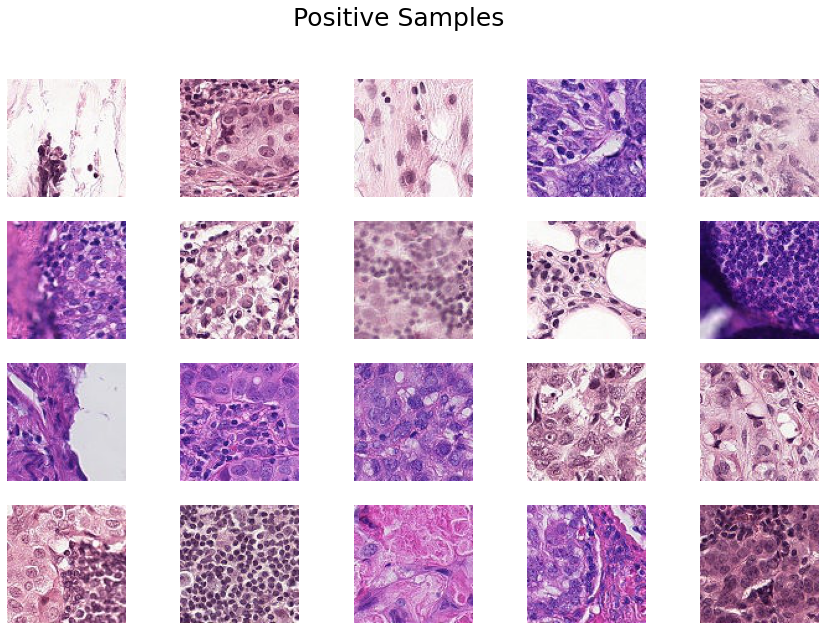

In [6]:
fig, ax = plt.subplots(4, 5, figsize=(15,10))
fig.suptitle('Positive Samples', fontsize = 25)
count = 1
for index, name in enumerate(positive_train_file_name.head(20)):
    file_name = 'train//'+ name + '.tif'
    img = Image.open(file_name)
    plt.subplot(4, 5, count)
    plt.imshow(np.array(img))
    plt.axis('off')
    count += 1

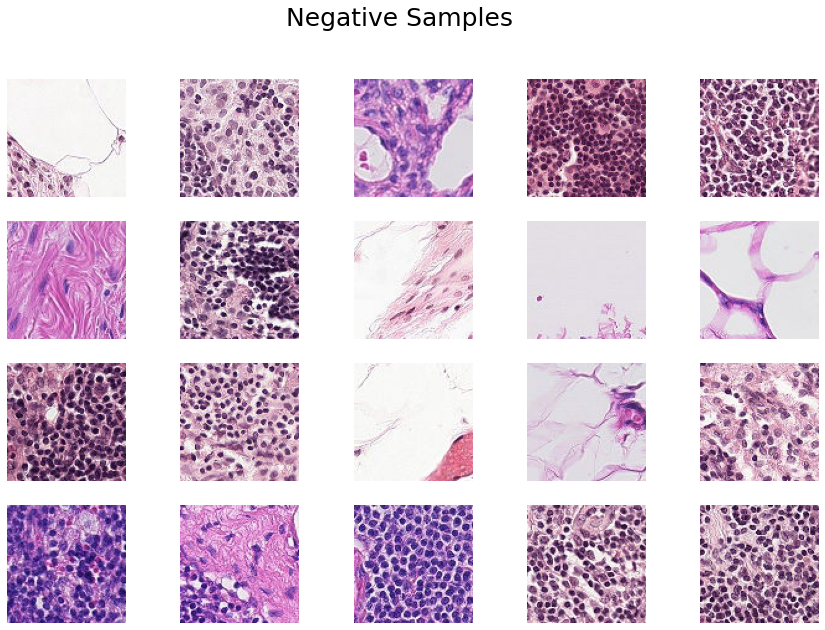

In [7]:
fig, ax = plt.subplots(4, 5, figsize=(15,10))
fig.suptitle('Negative Samples', fontsize = 25)
count = 1
for index, name in enumerate(negative_train_file_name.head(20)):
    file_name = 'train//'+ name + '.tif'
    img = Image.open(file_name)
    plt.subplot(4, 5, count)
    plt.imshow(np.array(img))
    plt.axis('off')
    count += 1

The above images are some positive samples and negative samples. It is difficult for amateur people to identify metastatic cancer with human eyes.

In [ ]:
#for index, row in train_label.iterrows():
#    shutil.copyfile('train//' + row[0] + '.tif', 'train_with_label//' + str(row[1]) + '//' + row[0] + '.tif')

Now, we are going to load the image data. First, we make folders with label and move the images to those folders in order to load the image correctly.

In [43]:
image_generator = ImageDataGenerator(rescale = 1 / 255,
                                     validation_split = 0.2)

In [47]:
train_dataset = image_generator.flow_from_directory(directory = 'train_with_label',
                                                    shuffle = True,
                                                    subset = "training",
                                                    class_mode = 'binary',
                                                    target_size = (96, 96))
validation_dataset = image_generator.flow_from_directory(directory = 'train_with_label',
                                                         shuffle = True,
                                                         subset = "validation",
                                                         class_mode = 'binary',
                                                         target_size = (96, 96))

Found 176021 images belonging to 2 classes.
Found 44004 images belonging to 2 classes.


Then, we use ImageDataGenerator to load the images and split into two datasets so we have a trainning dataset and a validation dataset.

## DModel Architecture

Now, we are going to build the model. My way to doing this is really trial and error way, I have tried a few times for a three layers model, but they got not a very good result, and then I took a look of the available models on Kaggle and made some changes to the model. The model that mostly inspired me is from FRANCESCO MARAZZI@Kaggle https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

In [100]:
model = Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape = (96, 96, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation ='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation = "sigmoid")
])

In [101]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_11 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)     

In [102]:
model.compile(optimizer = keras.optimizers.Adam(0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [103]:
callback = EarlyStopping(monitor='val_loss', patience = 3)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.001)
history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = 20,
                    callbacks = [callback, reduce_lr])

Epoch 1/20
5501/5501 [==============================] - 2355s 428ms/step - loss: 0.3604 - accuracy: 0.8465 - val_loss: 0.3225 - val_accuracy: 0.8685 - lr: 0.0010
Epoch 2/20
5501/5501 [==============================] - 1666s 303ms/step - loss: 0.2783 - accuracy: 0.8866 - val_loss: 0.3038 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 3/20
5501/5501 [==============================] - 1671s 304ms/step - loss: 0.2394 - accuracy: 0.9050 - val_loss: 0.2338 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 4/20
5501/5501 [==============================] - 1710s 311ms/step - loss: 0.2101 - accuracy: 0.9184 - val_loss: 0.5252 - val_accuracy: 0.8179 - lr: 0.0010
Epoch 5/20
5501/5501 [==============================] - 1672s 304ms/step - loss: 0.1974 - accuracy: 0.9238 - val_loss: 0.3180 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 6/20
5501/5501 [==============================] - 1762s 320ms/step - loss: 0.1797 - accuracy: 0.9313 - val_loss: 1.4113 - val_accuracy: 0.7937 - lr: 0.0010


## Results and Analysis

In [105]:
history.history

{'loss': [0.3603880703449249,
  0.2783055305480957,
  0.23935535550117493,
  0.21009835600852966,
  0.1973893791437149,
  0.17972218990325928],
 'accuracy': [0.8464728593826294,
  0.886559009552002,
  0.9050226807594299,
  0.9183563590049744,
  0.9238329529762268,
  0.9312979578971863],
 'val_loss': [0.3225317597389221,
  0.3038073480129242,
  0.23380105197429657,
  0.5252302289009094,
  0.3180446922779083,
  1.411266565322876],
 'val_accuracy': [0.8684664964675903,
  0.8782837986946106,
  0.9078265428543091,
  0.8178574442863464,
  0.8722161650657654,
  0.7937005758285522],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}

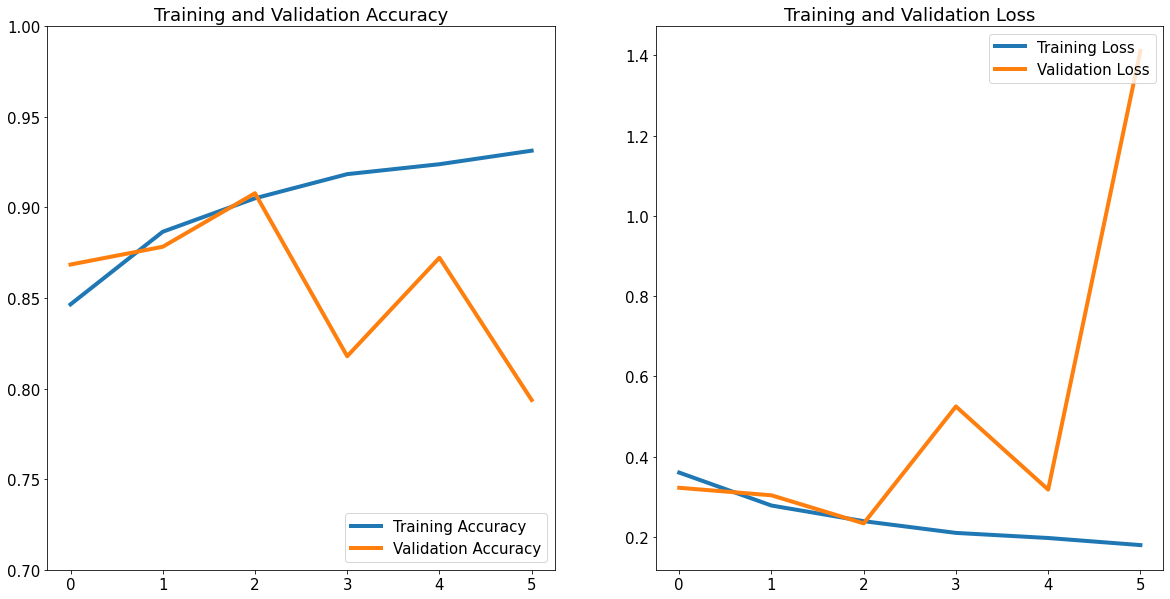

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.rc('font', size = 15)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth = 4)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth = 4)
plt.ylim(ymin = 0.7, ymax = 1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth = 4)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth = 4)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We trainned the model with 20 epochs and setting a callback which would be triggered when validation loss is increasing in more than 3 epoches, and the trainning finally stopped at epoch 6. We can see that training accuracy keeps going up, but validation accuracy fluctuates a lot, and this may due to overfitting problem.

In [136]:
loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

1376/1376 [==============================] - 349s 254ms/step - loss: 1.4113 - accuracy: 0.7937
Loss:  1.4112671613693237
Accuracy:  0.7937005758285522


The model scores 79.37% validation accuracy, and now we are going to predict the test dataset and submit the result.

In [138]:
test_image_generator = ImageDataGenerator(rescale = 1 / 255)
test_dataset = test_image_generator.flow_from_directory(directory = 'test',
                                                         shuffle = False,
                                                         class_mode = None,
                                                         target_size = (96, 96))

Found 57458 images belonging to 1 classes.


In [153]:
file_list = [file_name.split('.')[0] for file_name in os.listdir(os.path.join('test/test'))]
submission_df = pd.DataFrame(file_list, columns =['id'])

In [155]:
submission_df['label'] = model.predict(test_dataset)
submission_df.head()

1796/1796 [==============================] - 513s 286ms/step


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.007405
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.967745
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.006592
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.709810
4,000270442cc15af719583a8172c87cd2bd9c7746,0.000173


In [156]:
submission_df.to_csv('submission.csv', index = False)

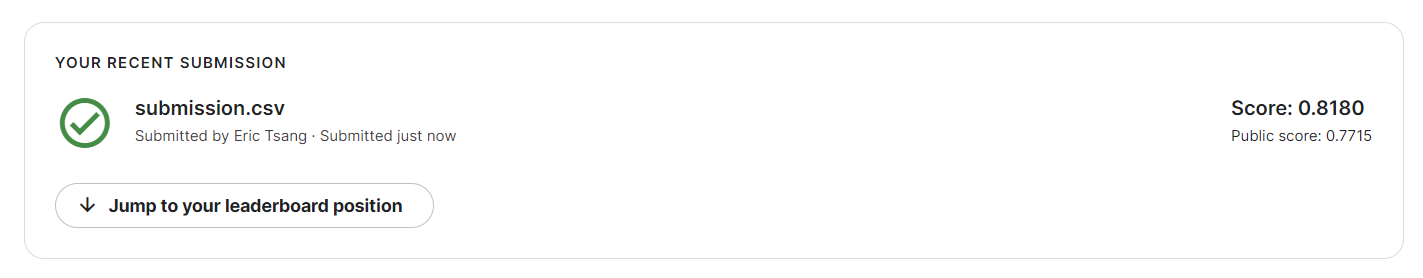

The test result is not bad, which has a score of 0.8180

## Conclusion 

Training a CNN model is not a easy job, it is actually quite tough. There are many ways to fine tune the model, we can keep changing the architecture of the model to see if it can get a better result, but it is really time consuming.

I think the model created in this project may be suffered from overfitting problem. We can use data augmentation to generate additional data for the model to be generalized better, and fine tuning the dropout parameter to achieve better regularization to the network.

Overall, it is quite amazing that technology can let amateur people like me to train a model to identify metastatic cancer, data science is really bringing a greate future for human civilization.